# Project 2: Causality, RCTs and two-sample tests

```
From ML Theory to Practice
Universität Potsdam, fall semester 2025

Authors: Juan L. Gamella and Simon Bing
License: CC-BY-4.0 https://creativecommons.org/licenses/by/4.0/
```

## Setup

These packages should already be installed in your Python virtual environment.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Connect to the Remote Lab

We will use the queue system for this project. Let's start the connection to the Remote Lab.

In [3]:
import causalchamber.lab as lab
rlab = lab.Lab(credentials_file = '../intermezzo/apikeys.txt')



Chambers

  Status   Chamber ID     Model              Mode    Valid Configurations  
───────────────────────────────────────────────────────────────────────────
  READY    lt-ptdm-fu3p   Light Tunnel Mk2   queue   'standard'            
───────────────────────────────────────────────────────────────────────────


Experiments

  Status   Tag                Experiment ID                          Chamber ID     Config     Submitted On                    
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  DONE     red_shift          1d2906d7-6b24-4c97-9519-416d56a34418   lt-ptdm-fu3p   standard   Mon, Nov 03, 2025 02:35:38 CET  
  DONE     red_shift          81413464-d58a-4cfd-9eef-ba487ea77cf2   lt-ptdm-fu3p   standard   Mon, Nov 03, 2025 02:33:52 CET  
  DONE     red_shift          d41199cd-2ef9-4621-b94d-342586ceb910   lt-ptdm-fu3p   standard   Mon, Nov 03, 2025 02:32:18 CET  
  DONE     red_shift         

### Helper functions

You can use the following helper function to monitor the completion of a list of experiments and download their data.

In [11]:
import time
def wait_and_download(ids, download_dir):
    """
    Given a list of experiment ids, wait for them to complete and download the data.
    """
    dataframes = []
    spinner = ['⠋', '⠙', '⠹', '⠸', '⠼', '⠴', '⠦', '⠧', '⠇', '⠏']
    print(f"Waiting for data from {len(ids)} experiment{'s' if len(ids) else ''}")
    for j,experiment_id in enumerate(ids):
        data = None        
        i = 0
        while data is None:
            try:
                data = rlab.download_data(experiment_id = experiment_id, root=download_dir)
            except lab.exceptions.UserError:
                print(f"  ({j+1}/{len(ids)}) waiting for {experiment_id} to finish {spinner[i]}", end='\r')
                i = (i+1) % len(spinner)            
        # Clear the line and return the data
        print(f"  ({j+1}/{len(ids)}) downloaded {experiment_id}                     ")
        dataframes.append(data.dataframe)
    return dataframes

And you can use this function to cancell all your currently queued experiments

In [12]:
def cancel_all():
    """
    Cancel all your queued experiments.
    """
    for experiment in rlab.get_experiments(verbose=False):
        if experiment['status'] == 'QUEUED':
            try:
                rlab.cancel_experiment(experiment['experiment_id'])
            except lab.exceptions.UserError:
                continue

## Performing a controlled experiment


We will begin by performing a simple controlled experiment to test the effect of the light source brightness on the other variables of the system.

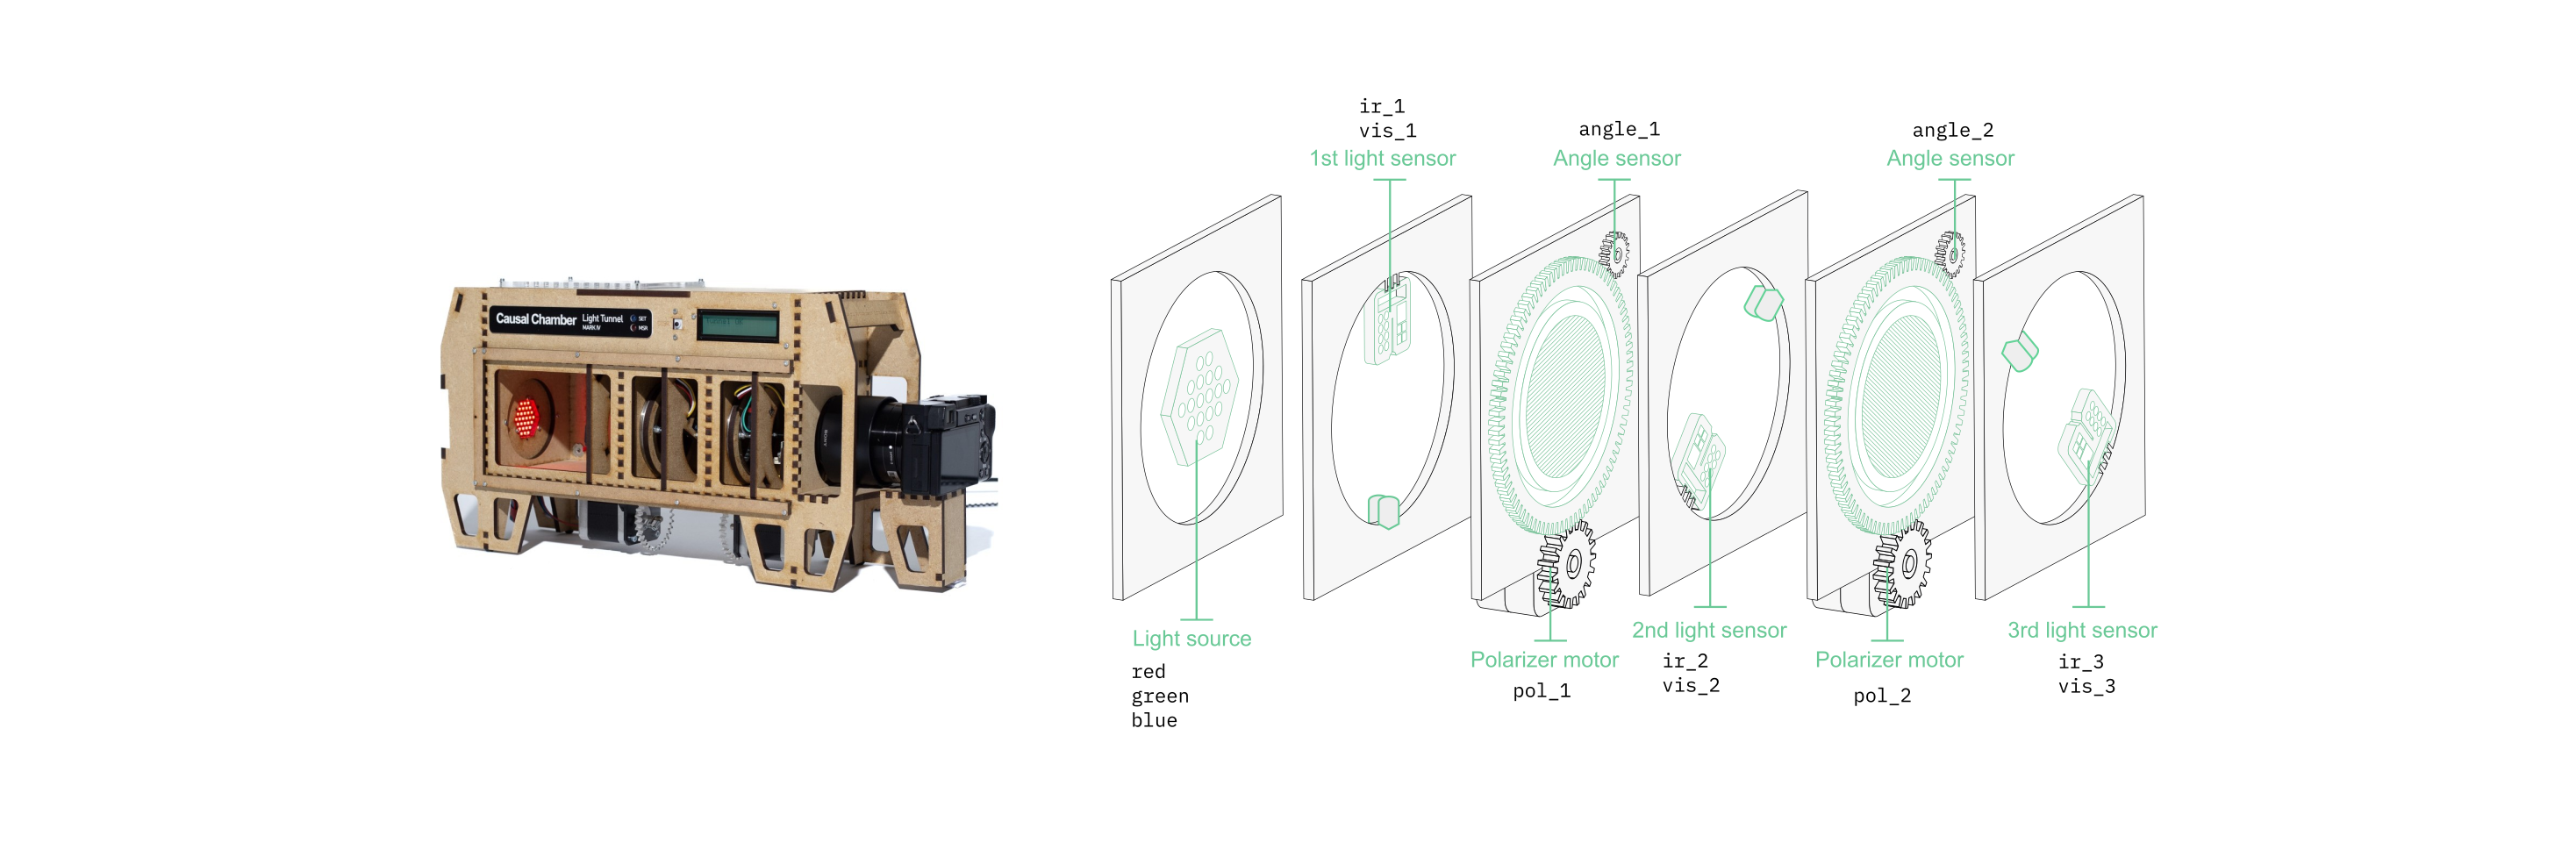

For our treatment, we will set `red=2`. As control, we will set `red=0` while keeping all other variables constant.

<mark style="background-color: #648fff;">Question:</mark> Consider the variables `ir_1, ir_2, vis_2, ir_3` and `angle_1`. Which do you expect to be affected by the change in red brightness?

> Hint: you can find a description of what these variables are [here](https://cchamber-box.s3.eu-central-2.amazonaws.com/config_doc_lt_mk2_standard.pdf)

Given that ir_1, ir_2, vis_2, ir_3 all measure light in some way I would expect all of them to be at least a bit affected by a change in red. Since angle_1 only givs us the angle of the first polarizer, I do not expect any change in angle_1 from a change in red.

<mark style="background-color: #40E0D0;"> Task </mark> 

Create and submit two experiments:

- For the control, set `red=0` and take `n=50` measurements
- For the treatment, set `red=2` and take `n=50` measurements

Remember that you can use `wait_and_download(...)` (defined above) to wait for completion and download the data.

In [18]:
experiment_ids = []

experiment = rlab.new_experiment(chamber_id = 'lt-ptdm-fu3p', config = 'standard')
N = 50
experiment.set('red', 0)
experiment.measure(n=N)
experiment_ids.append(experiment.submit(tag='red_control'))

experiment = rlab.new_experiment(chamber_id = 'lt-ptdm-fu3p', config = 'standard')
N = 50
experiment.set('red', 2)
experiment.measure(n=N)
experiment_ids.append(experiment.submit(tag='red_treatment'))

In [19]:
results = wait_and_download(experiment_ids, "./data_dir")


Waiting for data from 2 experiments



100%|██████████| 9.50k/9.50k [00:00<00:00, 5.50MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (1/2) downloaded d11f25d4-3e3f-4510-ba0f-3c260bc1339e                     



100%|██████████| 9.57k/9.57k [00:00<00:00, 4.65MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (2/2) downloaded dc9a71bc-ebf6-4050-98fe-f5c3dce8a0b2                     


,timestamp,counter,flag,intervention,red,green,blue,current_ls,current_ls_raw,offset_current_ls,...,res_current_led_3_ir,current_led_3_uv,current_led_3_uv_raw,offset_current_led_3_uv,sps_current_led_3_uv,res_current_led_3_uv,current_supply,current_supply_raw,pot_1_volts,pot_2_volts
0,704935.476480,0.0,0.0,0.0,0.0,0.0,0.0,0.000833,-20235.0,0.0,...,0.0,-0.034372,-20603.0,0.0,7.0,0.0,0.534058,8535.0,2.556152,2.546387
1,704935.582481,1.0,0.0,0.0,0.0,0.0,0.0,0.004564,-20196.0,0.0,...,0.0,-0.036094,-20621.0,0.0,7.0,0.0,0.879716,8757.0,2.549744,2.536011
2,704935.688477,2.0,0.0,0.0,0.0,0.0,0.0,0.002364,-20219.0,0.0,...,0.0,-0.043843,-20702.0,0.0,7.0,0.0,1.311010,9034.0,2.535095,2.540894
3,704935.794480,3.0,0.0,0.0,0.0,0.0,0.0,0.005999,-20181.0,0.0,...,0.0,-0.036668,-20627.0,0.0,7.0,0.0,0.280263,8372.0,2.547913,2.546997
4,704935.901487,4.0,0.0,0.0,0.0,0.0,0.0,0.013365,-20104.0,0.0,...,0.0,-0.028919,-20546.0,0.0,7.0,0.0,0.205527,8324.0,2.546387,2.547607
5,704936.008494,5.0,0.0,0.0,0.0,0.0,0.0,0.014131,-20096.0,0.0,...,0.0,-0.036381,-20624.0,0.0,7.0,0.0,1.321909,9041.0,2.564392,2.551880
6,704936.115497,6.0,0.0,0.0,0.0,0.0,0.0,0.008008,-20160.0,0.0,...,0.0,-0.035233,-20612.0,0.0,7.0,0.0,1.653554,9254.0,2.557983,2.550964
7,704936.221496,7.0,0.0,0.0,0.0,0.0,0.0,0.007339,-20167.0,0.0,...,0.0,-0.030832,-20566.0,0.0,7.0,0.0,0.903071,8772.0,2.550354,2.554321
8,704936.328503,8.0,0.0,0.0,0.0,0.0,0.0,0.002364,-20219.0,0.0,...,0.0,-0.033702,-20596.0,0.0,7.0,0.0,0.610352,8584.0,2.554321,2.550659
9,704936.435507,9.0,0.0,0.0,0.0,0.0,0.0,0.014992,-20087.0,0.0,...,0.0,-0.034563,-20605.0,0.0,7.0,0.0,1.139738,8924.0,2.544556,2.546387


<mark style="background-color: #40E0D0;"> Task </mark> 

Now, let's visualize the data. First, combine your control and treatment dataframes into one:

```python
combined = pd.concat([<control_df>, <treatment_df>], ignore_index=True)
```

and then you can compare the control and treatment histograms for a variable var by calling

```python
    sns.histplot(combined, x=var, hue='red')
```

Your turn!

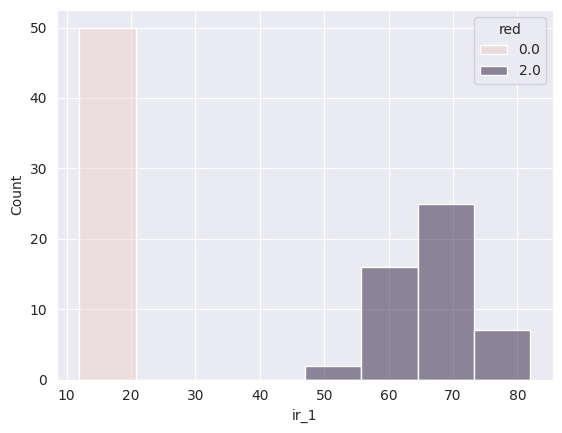

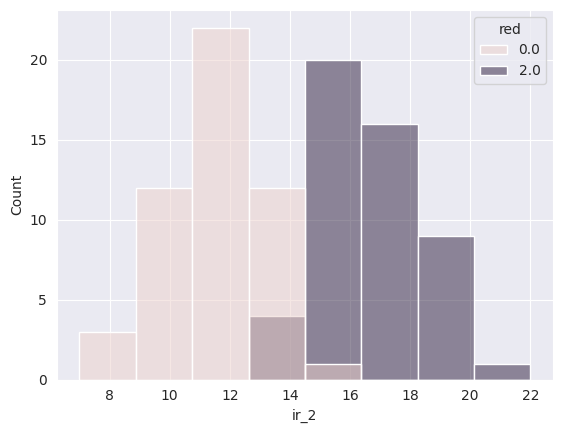

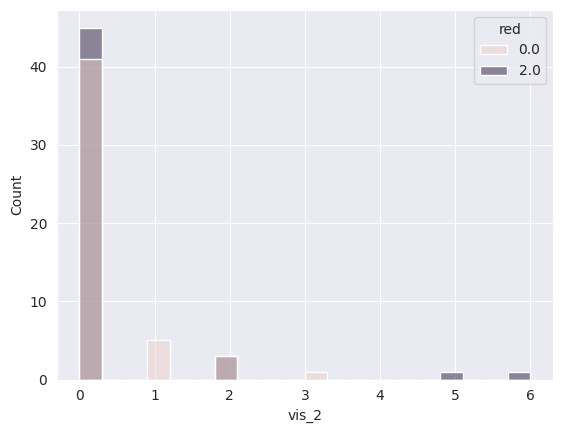

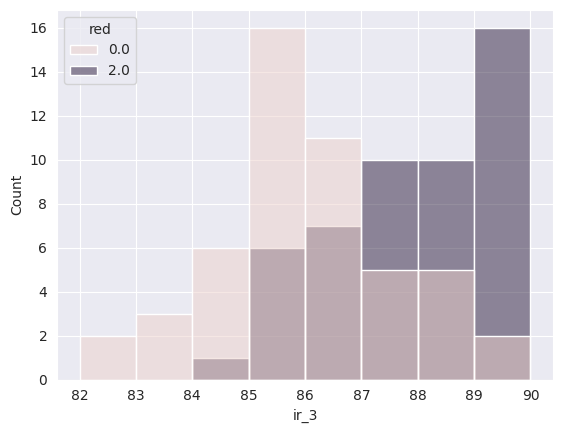

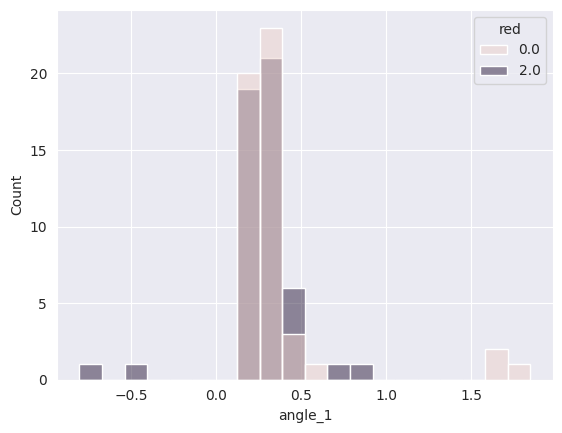

In [25]:
variables = ['ir_1', 'ir_2', 'vis_2', 'ir_3', 'angle_1']

combined = pd.concat(results, ignore_index=True)
for var in variables:
    sns.histplot(combined, x=var, hue='red')
    plt.show()

<mark style="background-color: #648fff;">Question:</mark> Which variables are affected by the change in `red` values? Do they match your prediction? Why / why not?

My prediction was correct for all variables exapt vor vis_2. Counterintuitivly red sems not to have a at measurable impact on vis_2. It seams unlikely that it has no impact at all, hence I believe the impact to be to small to be measurable.

## Performing a randomized control experiment

We will now repeat our experiment, but we will randomize our treatment and control assignments.

<mark style="background-color: #40E0D0;"> Task </mark> 

Create and submit `100` experiments where:

- Decide at random if this is a control or treatment experiment (hint: you can call `rng.choice([True, False])` to "flip a coin")
- Set `red=10` if treatment or `red=0` if control
- Collect `n=1` measurements

Then, wait for the experiments to finish and store the resulting data in a list called `dataframes`

In [26]:
experiment_ids = []
rng = np.random.default_rng(42)

for i in range(100):
    experiment = rlab.new_experiment(chamber_id = 'lt-ptdm-fu3p', config = 'standard')
    if rng.choice([True, False]):
        experiment.set('red', 0)
    else:
        experiment.set('red', 10)
    experiment.measure(n=1)
    experiment_ids.append(experiment.submit())
# Hint: you can call rng.choice([True, False]) to "flip a coin"

dataframes = wait_and_download(experiment_ids, download_dir="./data_dir")

Waiting for data from 100 experiments



100%|██████████| 1.79k/1.79k [00:00<00:00, 735kiB/s]

  Verifying checksum...

 done.
  Extracting zip-file contents to "./data_dir"... done.
  (1/100) downloaded 7f131843-3fca-444c-bdae-1886593c5800                     



100%|██████████| 1.81k/1.81k [00:00<00:00, 2.56MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (2/100) downloaded b20df179-b112-43c4-99de-8226d5b40ecb                     



100%|██████████| 1.81k/1.81k [00:00<00:00, 2.82MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (3/100) downloaded 8cdb71a7-c586-4cde-b48d-abe31e04417a                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 529kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (4/100) downloaded 27772c0a-8a84-4be0-9f7b-e31fa3e64780                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 973kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (5/100) downloaded 03f3e0ad-70a1-4396-84bf-e2cbac31d907                     



100%|██████████| 1.81k/1.81k [00:00<00:00, 2.00MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (6/100) downloaded 72f09dcd-4c0a-4e55-bd78-23558e5a6d89                     


100%|██████████| 1.80k/1.80k [00:00<00:00, 868kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (7/100) downloaded 269e3ccb-8816-494e-b012-16cb8d825120                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 771kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (8/100) downloaded 739af8ed-2f0f-4ba3-a4a7-164a15d8d82c                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 1.25MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (9/100) downloaded f638a914-3f94-41aa-b510-4ec1f7b21169                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 1.07MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (10/100) downloaded 9afdc9d0-63dd-4183-95d4-24939ac4454e                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 726kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (11/100) downloaded c94329f9-9e84-4b2e-ad4f-f435f990247d                     



100%|██████████| 1.81k/1.81k [00:00<00:00, 513kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (12/100) downloaded 46e275f9-3dde-4002-9316-bbc05953e05e                     



100%|██████████| 1.81k/1.81k [00:00<00:00, 2.66MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (13/100) downloaded f108212c-d773-41ea-98c4-90bebd821b1c                     



100%|██████████| 1.81k/1.81k [00:00<00:00, 2.47MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (14/100) downloaded 5fdc1834-3ac6-45c5-9125-fb11aa0fee50                     



100%|██████████| 1.81k/1.81k [00:00<00:00, 1.45MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (15/100) downloaded 1749b8e6-f349-4da3-a993-f1ed583a365a                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 871kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (16/100) downloaded 72d2dd97-b623-42c4-9d5f-d7ac780357ca                     



100%|██████████| 1.81k/1.81k [00:00<00:00, 958kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (17/100) downloaded 2509be94-e568-4ddb-9530-80bbc33a70c6                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 1.65MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (18/100) downloaded ecf3d0b1-80ba-42a8-8890-f0df29646681                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 286kiB/s]

  Verifying checksum...

 done.
  Extracting zip-file contents to "./data_dir"... done.
  (19/100) downloaded df856008-ddee-40b8-85c9-9136ab8875f8                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 2.57MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (20/100) downloaded 63852c9c-3dac-4e03-bf76-d2b446e4abb2                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 926kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (21/100) downloaded 75aa8666-3417-4635-a3a0-eac1a5a0994c                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 1.53MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (22/100) downloaded 0e817a3c-10db-48a3-a330-e20e8019995f                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 2.53MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (23/100) downloaded b087dcf4-a6f0-40d5-9c75-4a456d07c9e2                     



100%|██████████| 1.81k/1.81k [00:00<00:00, 1.20MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (24/100) downloaded 5e9e753c-034c-49d3-81f8-b6d6c30cc0d5                     



100%|██████████| 1.81k/1.81k [00:00<00:00, 1.73MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (25/100) downloaded 4bf3634c-9cb0-4456-9b14-9cf13a85aa9b                     



100%|██████████| 1.81k/1.81k [00:00<00:00, 1.20MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (26/100) downloaded e7094b64-03ee-40a4-b444-a3d473dee3a1                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 580kiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (27/100) downloaded d6b5d2ea-4bdb-400f-a79a-64e61c158a39                     


100%|██████████| 1.79k/1.79k [00:00<00:00, 2.58MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (28/100) downloaded 8f5b0d01-6ef2-490b-b37c-e2a072d4645f                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 3.15MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (29/100) downloaded 6aa48570-c919-4a4a-aa46-85c0f2526149                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 756kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (30/100) downloaded 1c94b048-24d4-41a6-b0da-21f343a49599                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 1.63MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (31/100) downloaded b7f36ab9-cadd-4c4b-94cd-6daefb29e010                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 734kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (32/100) downloaded 9670181f-8b81-465f-b45e-123d40345152                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 769kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (33/100) downloaded 84456988-04cb-4361-8b65-b991f339d9f3                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 1.94MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (34/100) downloaded 68c2ec74-182b-4afe-911a-07af623b1a49                     



100%|██████████| 1.81k/1.81k [00:00<00:00, 3.44MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (35/100) downloaded 4c2aeebd-4d9e-41fa-b778-578fb0e1ed66                     


100%|██████████| 1.81k/1.81k [00:00<00:00, 2.50MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (36/100) downloaded 76d68e3d-f519-4c70-afda-206f1c384538                     



100%|██████████| 1.81k/1.81k [00:00<00:00, 1.74MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (37/100) downloaded 7b2ca75b-6bf2-45cd-9bc7-d6534319c897                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 746kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (38/100) downloaded bfcec342-fc49-4858-8561-9c5c4b037404                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 700kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (39/100) downloaded 1bae0fae-c802-4cd7-973d-21c6b2455c8a                     



100%|██████████| 1.81k/1.81k [00:00<00:00, 2.18MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (40/100) downloaded 813460b3-8605-4a52-983e-a0d837fb3a61                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 2.55MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (41/100) downloaded 03372071-a4f8-4825-93a5-716d680ed47a                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 2.39MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (42/100) downloaded 88e77e81-1883-4919-8e7c-d4da27635ae5                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 1.68MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (43/100) downloaded 726fc4e4-63b3-4950-a050-ca0b8eab8f36                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 3.29MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (44/100) downloaded a6b37a00-9149-45f9-8fe9-8f0b4a012e5d                     



100%|██████████| 1.78k/1.78k [00:00<00:00, 2.82MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (45/100) downloaded 3d22fcbc-afe9-42fe-9139-2a59a1ac685d                     



100%|██████████| 1.81k/1.81k [00:00<00:00, 694kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (46/100) downloaded 83e1b97b-bbb8-4ff0-9e1e-37f85ee721d6                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 1.95MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (47/100) downloaded 4f575f6d-81bc-4251-9c74-90794a4d97b9                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 709kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (48/100) downloaded bc155832-0790-4ff7-bbf2-36d8914be168                     



100%|██████████| 1.81k/1.81k [00:00<00:00, 1.64MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (49/100) downloaded 8b8c61fc-d45e-4967-8ee1-d85da99e741a                     



100%|██████████| 1.81k/1.81k [00:00<00:00, 2.72MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (50/100) downloaded 648085fb-374f-4afb-9a9b-24bea7b28071                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 633kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (51/100) downloaded 51f3e3c1-c003-486b-b8a2-f9daa06795be                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 1.26MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (52/100) downloaded dc25e236-5fb9-4497-89f1-f86d220098cb                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 823kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (53/100) downloaded d0483bb9-a53d-4156-a505-9028fce88990                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 520kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (54/100) downloaded 9305dfa4-bf31-4f32-8563-bec3ae649d95                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 1.41MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (55/100) downloaded 7f1d962f-d3de-4003-bd58-040d77ef1eeb                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 2.31MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (56/100) downloaded fc7b81db-eb24-43fc-acd4-8f02e6dd489b                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 913kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (57/100) downloaded 9d4c3d89-75bb-4d4d-8ffa-230dc92a3b60                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 2.41MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (58/100) downloaded cb4b1c9d-7fe7-4bea-a573-4de848772479                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 1.95MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (59/100) downloaded 6aeeec02-aaa5-4e3e-ba08-1a0d97c25d54                     


100%|██████████| 1.79k/1.79k [00:00<00:00, 2.45MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (60/100) downloaded 74d6c5aa-2a95-447a-8e30-3d7ab98204bb                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 2.00MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (61/100) downloaded 7df47cd5-7351-4562-a8ed-3c45ff4d2d6c                     


100%|██████████| 1.80k/1.80k [00:00<00:00, 1.63MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (62/100) downloaded 16908a20-07fe-48c6-9e3a-7ef5619c353a                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 1.67MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (63/100) downloaded 94ccb3a7-fea6-4102-a298-58e667b677b9                     


100%|██████████| 1.80k/1.80k [00:00<00:00, 3.31MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (64/100) downloaded e32e1ab9-2247-412b-9a9d-193239493345                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 843kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (65/100) downloaded e3b130a0-9d4c-469c-96ee-4116963e575b                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 959kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (66/100) downloaded 4d1d30a5-c3de-4e6f-9358-065cb92c0c0d                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 570kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (67/100) downloaded 42a5b346-9375-4f5b-b5cb-7a940db7e517                     



100%|██████████| 1.81k/1.81k [00:00<00:00, 2.60MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (68/100) downloaded 1c2bb09f-1153-4cf6-b1e5-1eecd7398efb                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 1.86MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (69/100) downloaded ff8fdaec-054e-4a21-9467-4e2a7b71c077                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 1.52MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (70/100) downloaded 1f427f65-8898-4ad4-9428-f698366ee6ca                     



100%|██████████| 1.81k/1.81k [00:00<00:00, 1.96MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (71/100) downloaded c72df33b-fa28-42b5-978f-a7079cd3281d                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 1.10MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (72/100) downloaded b1dfc150-934e-4271-8fa1-315bb3b01f16                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 2.73MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (73/100) downloaded fb061734-0ced-4136-91d1-3715fbaed1b7                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 1.44MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (74/100) downloaded 684fd9bf-69fe-4889-884f-185a65c3a077                     



100%|██████████| 1.81k/1.81k [00:00<00:00, 2.71MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (75/100) downloaded 0ede9ba5-d15b-4678-acbf-d37aa08fbdab                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 1.55MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (76/100) downloaded 25e1f70f-9f16-45e3-8c8f-aec5f3afb35f                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 3.67MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (77/100) downloaded 28243f2b-167c-4706-88db-e6aa735762bd                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 2.33MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (78/100) downloaded 3be8a4da-77b0-4863-b310-f2cdacd4b5dc                     



100%|██████████| 1.81k/1.81k [00:00<00:00, 2.59MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (79/100) downloaded a1462424-1ea4-4427-a6c5-d634f6e54ac3                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 3.51MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (80/100) downloaded 0222bcbc-b500-4e34-86b9-72e939357221                     


100%|██████████| 1.80k/1.80k [00:00<00:00, 2.55MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (81/100) downloaded 4ec27ccb-b184-4743-92f9-f024e9e856c6                     



100%|██████████| 1.78k/1.78k [00:00<00:00, 1.20MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (82/100) downloaded aaf24225-81ad-4708-9b83-b514de9f667d                     



100%|██████████| 1.77k/1.77k [00:00<00:00, 1.86MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (83/100) downloaded 36e0972b-8f7f-447f-83ad-e72acc7ad060                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 1.38MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (84/100) downloaded e9378001-b785-44cc-88ce-f91c1c5d0bb7                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 1.58MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (85/100) downloaded c9e12887-b96b-47eb-bae2-d016d220808e                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 3.03MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (86/100) downloaded 576b6880-ef82-4396-9387-d4deb992b088                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 700kiB/s]

  Verifying checksum...

 done.
  Extracting zip-file contents to "./data_dir"... done.
  (87/100) downloaded 7d35b82d-1158-4a47-9820-18018656bd67                     



100%|██████████| 1.77k/1.77k [00:00<00:00, 426kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (88/100) downloaded 3dfd59cc-56ab-435f-bcfb-7a30a9e11c4e                     



100%|██████████| 1.78k/1.78k [00:00<00:00, 1.59MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (89/100) downloaded 63cfa98c-b4c7-42fb-84d7-f8bbe2da539b                     


100%|██████████| 1.80k/1.80k [00:00<00:00, 1.59MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (90/100) downloaded ea59dbbe-68ea-4f7c-a078-3681e9b7ac81                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 714kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (91/100) downloaded 156c8483-562b-42aa-aff6-e24e48354420                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 553kiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (92/100) downloaded 67744987-eb8d-4732-816d-637c9828461d                     


100%|██████████| 1.79k/1.79k [00:00<00:00, 1.41MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (93/100) downloaded 65b45d69-4875-480b-b5f0-00955b3eac9d                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 3.82MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (94/100) downloaded 012f4125-f8b0-4f49-bdc8-27a77207e25d                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 1.26MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (95/100) downloaded 345e4322-f733-4746-9c10-bf250f68db5f                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 749kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (96/100) downloaded 3586c72d-c569-4e4e-8b87-00a6f559aa49                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 1.92MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (97/100) downloaded c0a74e6c-1f46-4d71-bc21-16bea1f9f0da                     



100%|██████████| 1.80k/1.80k [00:00<00:00, 877kiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (98/100) downloaded 4f7ec3bc-a31d-4084-a381-f79fb27c97cf                     



100%|██████████| 1.81k/1.81k [00:00<00:00, 2.04MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (99/100) downloaded 82691992-b2bc-4644-90ee-d3994a1e19ca                     



100%|██████████| 1.79k/1.79k [00:00<00:00, 2.33MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (100/100) downloaded 09385b91-2de1-48ae-b20e-51492a13c0e4                     


<br>

<mark style="background-color: #40E0D0;"> Task </mark>

Now lets visualize the results. Again, you can combine all the data by calling

In [27]:
data = pd.concat(dataframes, ignore_index=True)

and then plot the marginal distributions by calling

```python
sns.histplot(data, x=<variable_name>, hue='red')
```

Plot the new data and compare the distributions of treatment and effect.

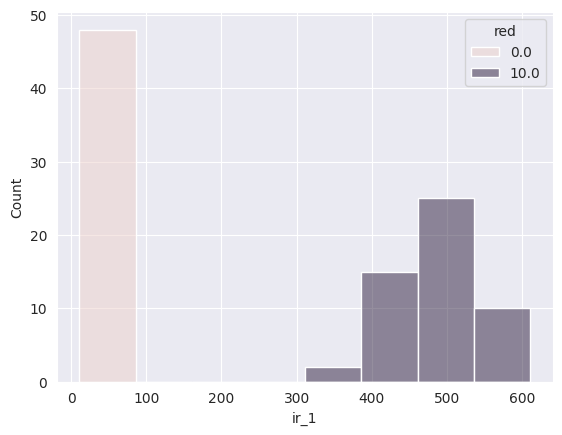

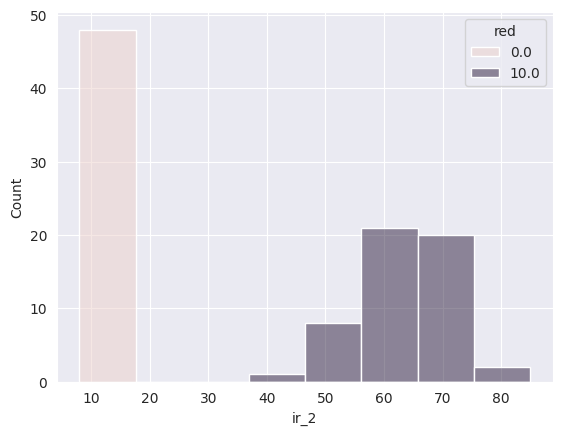

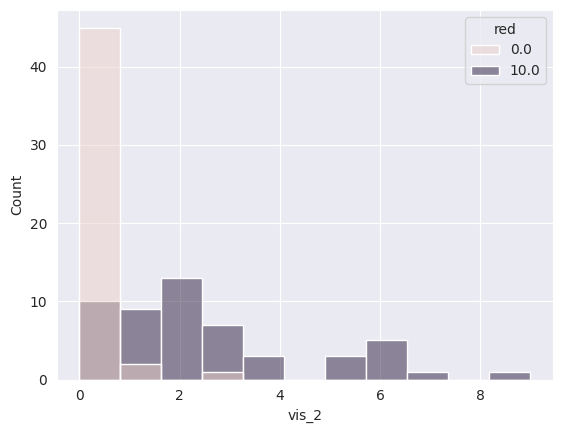

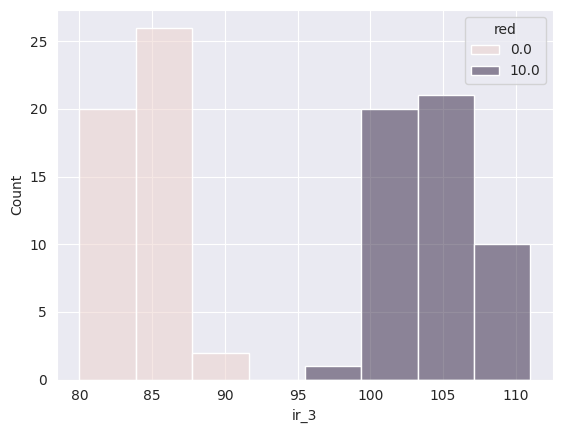

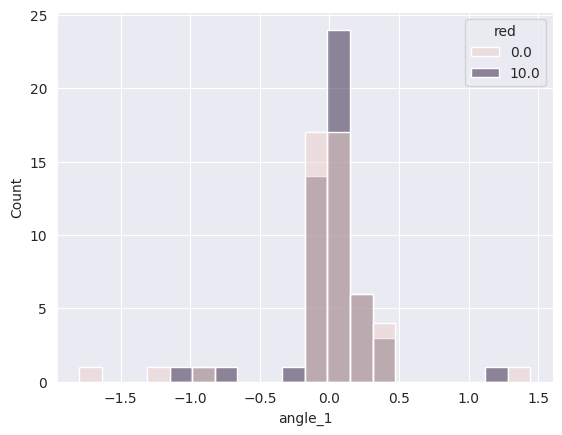

In [31]:
for var in variables:
    sns.histplot(data, x=var, hue='red')
    plt.show()

<mark style="background-color: #648fff;">Question:</mark> Which variables are affected by the change in `red` values? What has changed with respect to the non-randomized experiment?

It is now clear that vis_2 is also effected by the change in x. Also for the other variables the difference in the distribution is more pronounced, but it is unclear to me whether that is due to it being randomised or it bing a higher value of red.

Therefor I will repeat the non-randomised experiment with red=10.

Waiting for data from 2 experiments



100%|██████████| 9.51k/9.51k [00:00<00:00, 6.18MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (1/2) downloaded 801d8473-8763-4385-8559-b15fd33b7f4c                     



100%|██████████| 9.62k/9.62k [00:00<00:00, 10.6MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (2/2) downloaded 9ba4eefb-8ded-4c8a-aa36-4d97c64d10cd                     


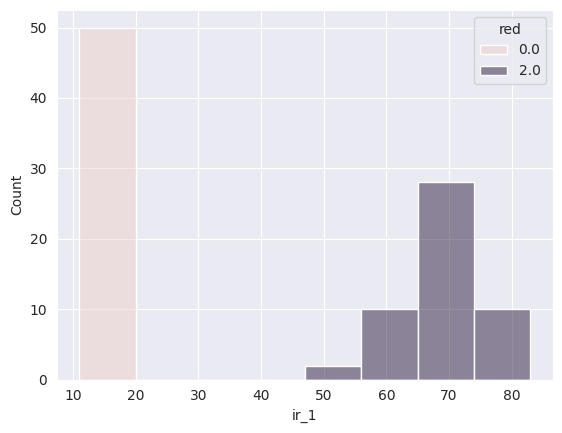

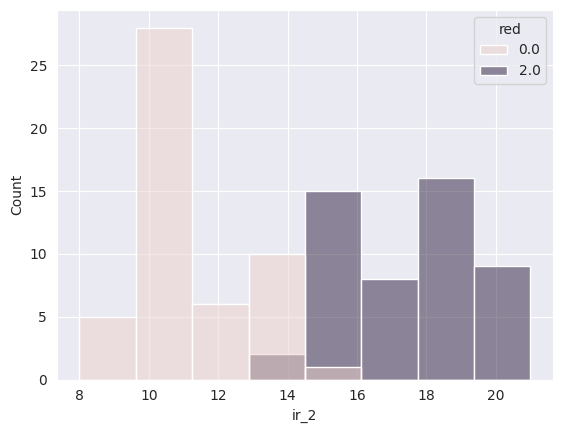

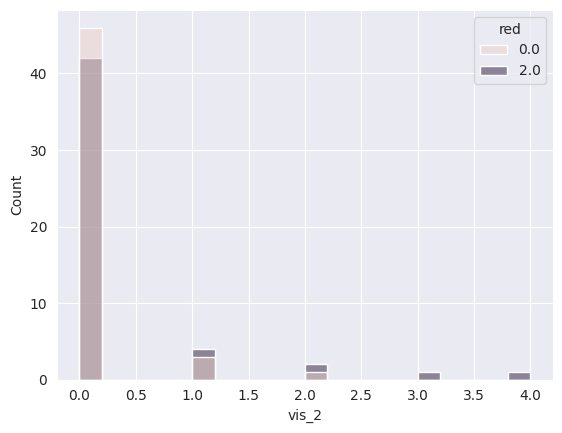

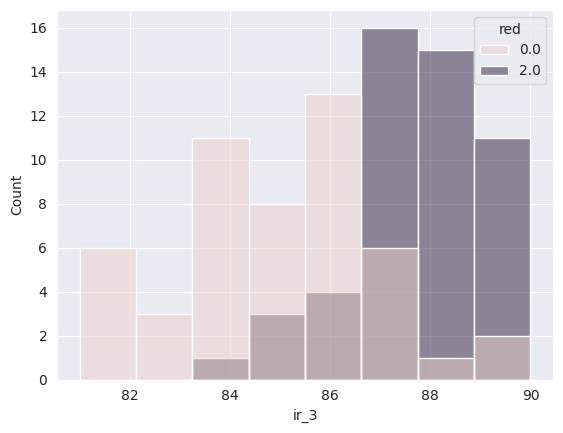

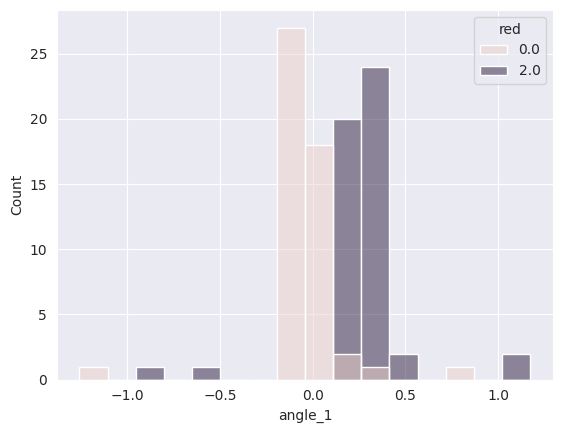

In [30]:
experiment_ids = []

experiment = rlab.new_experiment(chamber_id='lt-ptdm-fu3p', config='standard')
N = 50
experiment.set('red', 0)
experiment.measure(n=N)
experiment_ids.append(experiment.submit(tag='red_control'))

experiment = rlab.new_experiment(chamber_id='lt-ptdm-fu3p', config='standard')
N = 50
experiment.set('red', 2)
experiment.measure(n=N)
experiment_ids.append(experiment.submit(tag='red_treatment'))
results = wait_and_download(experiment_ids, "./data_dir")
combined2 = pd.concat(results, ignore_index=True)
for var in variables:
    sns.histplot(combined2, x=var, hue='red')
    plt.show()

This time, ir_2, ir_3 are less clear, vis_2 looks not effected by red at all and funnyly enough this time angle_1 looks as if it were effected by red.

## Two-sample testing

Above, you visually evaluated the results to see if there was a difference between treatment and effect. But how can we do this in a quantifiable way? If our measurements contain noise, how can we make sure that what we observed was not simply chance?

Enter: the two-sample test, one of statistics oldest problems (and the one we can solve best).

### The student t-test

We will begin by looking at perhaps one of the oldest (and still widely used) two-sample tests: The student [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test)

In [32]:
from scipy.stats import ttest_ind

Let's try the t-test on the data from our randomized experiment above. We will compare the treatment vs. control distributions of each variable.

<mark style="background-color: #648fff;">Question:</mark> Before you start, what do you expect the p-values to look like for each variable? Which do you expect to be higher / lower? Explain your reasoning.

I expect the p-values for first four variables to be small, since they have a different mean dependent on the value of red. For angle_1 on the other hand, since the Null-hypothesis should be true, the p-value is egually distributed, therefore no value for it is more likely than any other.

<mark style="background-color: #40E0D0;"> Task </mark> 

Compute and print the p-value resulting from comparing the treatment & control distributions for each variable. To compute the p-value, you can call

```python
ttest_ind(<control_sample>, <treatment_sample>).pvalue
```

In [34]:
variables = ['ir_1', 'ir_2', 'vis_2', 'ir_3', 'angle_1']

control_sample = data[data['red'] == 0]
treatment_sample = data[data['red'] == 10]
for var in variables:
 pvalue = ttest_ind(control_sample[var], treatment_sample[var]).pvalue
 print(f"p-value for {var}: {pvalue:.3f}")

p-value for ir_1: 0.000
p-value for ir_2: 0.000
p-value for vis_2: 0.000
p-value for ir_3: 0.000
p-value for angle_1: 0.639


<mark style="background-color: #648fff;">Question:</mark> Did the results match your expectations?

Yes.

<mark style="background-color: #648fff;">Question:</mark> In your own words, explain what the null hypothesis of the test is in this case, and what the p-value represents.

The function ttest_ind() states in its dockstring that it checks how likely it is, that the given samples come from a distribution with the same mean. We whant to check if 'red' has an effect on the other variables, so the null hypothesis assumes hat the two samples come from the same distribution, i.e. have the same mean. The super low p-values for the 'ir_'s and 'vis_2' means that we can reject the null hypothesis. They come from distributions with a different mean.

<mark style="background-color: #648fff;">Question:</mark> Say you want to reject the null-hypothesis at level $\alpha = 0.05$. For which variables do you find a significant effect?

'ir_1', 'ir_2', 'vis_2' and  'ir_3'

### Evaluating level and power

We will now evaluate the level and power of the t-test.

<mark style="background-color: #648fff;">Question:</mark> Can you explain, in your own words, the difference between a type-I error and a type-II error?

Type-I-error: We reject the null hypothesis, even though it is true.

Type-II-error: We do not reject the null hypothesis, even though it is not true.

<mark style="background-color: #648fff;">Question:</mark> Based on your answer, what is the difference between level and power?

The level is the likelyhood of a type-I-error happening. The power is 1-$\beta$ where $\beta$ is the likelyhood of a type-II-error happening.

<mark style="background-color: #40E0D0;"> Task </mark> 

Now, we will evaluate the level and power of the t-test on a hundred repetitions of our experiment.

To save time, we will do the randomization at the _observation_ level, instead of at the experiment level. In particular, create and submit 100 experiments where,

For each experiment:

1. flip a coin (i.e., `rng.choice([True, False])`) and set `red=0` or `red=2` depending on the result
2. collect one measurement
3. repeat steps 1 and 2 ten times, for a total of `100` measurements
4. submit the experiment

You can store the resulting experiment ids in a list called `experiment_ids`. Download the results using `wait_and_download(...)` and store them into a list called `dataframes`.

We suggest you print the experiment ids and store them somehwere (e.g., in a text cell of this notebook) so you don't have to resubmit the experiments if you close the notebook.

In [37]:
cancel_all()

In [38]:
experiment_ids = []
rng = np.random.default_rng(42)

for k in range(100): # Outer loop for 100 experiments
    experiment = rlab.new_experiment(chamber_id = 'lt-ptdm-fu3p', config = 'standard')
    for i in range(100): # Inner measurement loop
        if rng.choice([True, False]):
            experiment.set('red', 0)
        else:
            experiment.set('red', 2)
        experiment.measure(n=1)
    experiment_ids.append(experiment.submit())
print(repr(experiment_ids)) # Print experiment ids so you can access them at any time

['524a9b8b-ea64-40b0-8f6b-555a897e69ad', '463ef9af-22c4-4249-94fc-bd2cfee3b869', '1f548260-5ad3-4246-a780-deda01e4fbb6', 'faad95ad-522f-4e5b-abb5-faec4dea0065', '8ca58f07-aa8b-4713-9f16-3c5909e57840', 'f21bc161-dae5-4a7b-a8d6-4690afd83e59', 'e1eb7ba6-3dfd-4998-b092-59a3f3b34ba9', '572a932b-ab56-4930-8dd0-45473b99bfcf', 'bc70df62-3428-4d35-8c6c-e76ded65ed0b', '1566f569-6609-4790-a193-1b8575dc0995', 'e936906f-7ad5-40aa-b6ec-fed57eabcaa7', 'f61ca06c-42d7-409b-a24b-8b708177296c', '2b4df1a3-c77f-4852-b655-7084b1d0b6d9', '1da99611-0dbb-4335-ad41-a665970da533', 'da117d2b-e247-4d81-8c1f-164d0913e275', '404b228c-767a-4371-84d2-11fd8972f374', 'a9571abd-1011-4149-8659-9124b96e0df1', 'bf8c46e2-172e-45ec-a732-f28855cb6602', '8e37cd9a-90db-402f-8626-dcbb35d378cd', '45804d94-571e-4c6b-b1ff-e1ffc845766d', '7d77b7db-b5dc-4ed5-9202-89bbf5ba0a85', 'bbf67534-9168-4f83-bc48-eabdd8628268', '7230d202-4d2f-4775-9dbc-44e64da07167', 'fc7ccc69-f7bc-4a77-b1e8-ecc5f97d79ff', 'dbfe0c9c-3972-450b-96f0-d860f385178d',

In [39]:
dataframes = wait_and_download(experiment_ids, download_dir="./data_dir")

Waiting for data from 100 experiments



100%|██████████| 16.4k/16.4k [00:00<00:00, 4.67MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (1/100) downloaded 524a9b8b-ea64-40b0-8f6b-555a897e69ad                     



100%|██████████| 16.3k/16.3k [00:00<00:00, 2.60MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (2/100) downloaded 463ef9af-22c4-4249-94fc-bd2cfee3b869                     



100%|██████████| 16.0k/16.0k [00:00<00:00, 4.85MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (3/100) downloaded 1f548260-5ad3-4246-a780-deda01e4fbb6                     



100%|██████████| 15.9k/15.9k [00:00<00:00, 6.52MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (4/100) downloaded faad95ad-522f-4e5b-abb5-faec4dea0065                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 4.30MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (5/100) downloaded 8ca58f07-aa8b-4713-9f16-3c5909e57840                     



100%|██████████| 16.4k/16.4k [00:00<00:00, 9.16MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (6/100) downloaded f21bc161-dae5-4a7b-a8d6-4690afd83e59                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 3.95MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (7/100) downloaded e1eb7ba6-3dfd-4998-b092-59a3f3b34ba9                     



100%|██████████| 16.3k/16.3k [00:00<00:00, 5.23MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (8/100) downloaded 572a932b-ab56-4930-8dd0-45473b99bfcf                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 4.14MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (9/100) downloaded bc70df62-3428-4d35-8c6c-e76ded65ed0b                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 1.72MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (10/100) downloaded 1566f569-6609-4790-a193-1b8575dc0995                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 6.84MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (11/100) downloaded e936906f-7ad5-40aa-b6ec-fed57eabcaa7                     



100%|██████████| 16.3k/16.3k [00:00<00:00, 2.00MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (12/100) downloaded f61ca06c-42d7-409b-a24b-8b708177296c                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 1.97MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (13/100) downloaded 2b4df1a3-c77f-4852-b655-7084b1d0b6d9                     



100%|██████████| 16.3k/16.3k [00:00<00:00, 1.82MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (14/100) downloaded 1da99611-0dbb-4335-ad41-a665970da533                     



100%|██████████| 15.9k/15.9k [00:00<00:00, 11.3MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (15/100) downloaded da117d2b-e247-4d81-8c1f-164d0913e275                     



100%|██████████| 16.1k/16.1k [00:00<00:00, 8.16MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (16/100) downloaded 404b228c-767a-4371-84d2-11fd8972f374                     



100%|██████████| 16.3k/16.3k [00:00<00:00, 12.7MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (17/100) downloaded a9571abd-1011-4149-8659-9124b96e0df1                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 5.05MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (18/100) downloaded bf8c46e2-172e-45ec-a732-f28855cb6602                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 12.2MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (19/100) downloaded 8e37cd9a-90db-402f-8626-dcbb35d378cd                     


100%|██████████| 16.0k/16.0k [00:00<00:00, 2.40MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (20/100) downloaded 45804d94-571e-4c6b-b1ff-e1ffc845766d                     



100%|██████████| 16.0k/16.0k [00:00<00:00, 11.0MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (21/100) downloaded 7d77b7db-b5dc-4ed5-9202-89bbf5ba0a85                     



100%|██████████| 15.9k/15.9k [00:00<00:00, 4.72MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (22/100) downloaded bbf67534-9168-4f83-bc48-eabdd8628268                     



100%|██████████| 16.1k/16.1k [00:00<00:00, 7.02MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (23/100) downloaded 7230d202-4d2f-4775-9dbc-44e64da07167                     



100%|██████████| 16.4k/16.4k [00:00<00:00, 4.82MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (24/100) downloaded fc7ccc69-f7bc-4a77-b1e8-ecc5f97d79ff                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 3.50MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (25/100) downloaded dbfe0c9c-3972-450b-96f0-d860f385178d                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 6.80MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (26/100) downloaded 755c0aa4-2bf7-4c23-ab42-2eec51a59f5c                     



100%|██████████| 16.1k/16.1k [00:00<00:00, 4.25MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (27/100) downloaded c0930ee6-2ed0-43a5-bdc7-1e6d2d07abbd                     



100%|██████████| 16.3k/16.3k [00:00<00:00, 5.17MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (28/100) downloaded 2262cff8-6e15-4235-beae-97171948cc07                     



100%|██████████| 16.5k/16.5k [00:00<00:00, 4.38MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (29/100) downloaded b6c5e3b1-5447-48bb-b79a-8ecbaec88b8c                     



100%|██████████| 15.9k/15.9k [00:00<00:00, 3.58MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (30/100) downloaded 56826328-8c66-4a75-b3f9-9bb7c392d3b4                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 4.65MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (31/100) downloaded d0190d38-52fe-46e4-901d-b7ae30dead94                     



100%|██████████| 15.9k/15.9k [00:00<00:00, 2.65MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (32/100) downloaded 6140acd6-7fa0-474a-b18d-12b87c6acf3b                     



100%|██████████| 16.3k/16.3k [00:00<00:00, 14.3MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (33/100) downloaded e6451668-3079-424a-9669-a9d027f99529                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 4.46MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (34/100) downloaded 2f66b870-67e0-465f-acf7-d788e4656fbb                     



100%|██████████| 16.3k/16.3k [00:00<00:00, 4.07MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (35/100) downloaded d36ed0e6-196b-4aca-beb6-cbaba11428cb                     



100%|██████████| 16.5k/16.5k [00:00<00:00, 8.11MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (36/100) downloaded 391ef3fb-bf9d-4cc4-b114-ff8c7109ab6d                     



100%|██████████| 16.6k/16.6k [00:00<00:00, 3.91MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (37/100) downloaded 55683b5d-042c-468c-8e51-7cb7bb9e0f69                     



100%|██████████| 16.3k/16.3k [00:00<00:00, 6.74MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (38/100) downloaded 6386f7d0-65c1-47f4-942b-844ea68c1838                     



100%|██████████| 16.0k/16.0k [00:00<00:00, 6.54MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (39/100) downloaded e8871ebf-89b9-4ed4-a5a5-e5e1c50b9091                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 15.5MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (40/100) downloaded 3da899e3-e20c-4be6-aec9-1330e3285ccc                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 4.51MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (41/100) downloaded 1a80a7ba-c4e8-4743-a692-76bb696b1a35                     



100%|██████████| 16.3k/16.3k [00:00<00:00, 4.57MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (42/100) downloaded 31f62ee7-71fb-42d2-890c-ea503a86bdf7                     



100%|██████████| 16.4k/16.4k [00:00<00:00, 3.87MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (43/100) downloaded 430f9b64-0311-4fdf-a33b-7a7b011f6e2f                     



100%|██████████| 16.1k/16.1k [00:00<00:00, 2.05MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (44/100) downloaded fa017712-40e7-4561-ac89-60ecf87d246d                     



100%|██████████| 16.1k/16.1k [00:00<00:00, 2.82MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (45/100) downloaded afa086f5-3d27-4362-9cb1-668903e3e13f                     



100%|██████████| 16.3k/16.3k [00:00<00:00, 2.14MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (46/100) downloaded b78db4bd-fafd-4f29-a0d8-7f2de8cdb996                     



100%|██████████| 16.4k/16.4k [00:00<00:00, 2.45MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (47/100) downloaded d759adc7-8265-423e-925d-6197bbaff7c8                     



100%|██████████| 16.1k/16.1k [00:00<00:00, 3.81MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (48/100) downloaded 2bfd0190-2e82-4e45-a8f9-6fbbe78a9f2b                     



100%|██████████| 16.1k/16.1k [00:00<00:00, 3.61MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (49/100) downloaded 528dd7eb-dcba-4159-bf3e-7db4c79b874d                     



100%|██████████| 16.0k/16.0k [00:00<00:00, 3.18MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (50/100) downloaded 033e6636-b2b9-459a-a562-8d50db052e23                     



100%|██████████| 16.0k/16.0k [00:00<00:00, 9.95MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (51/100) downloaded a85a5584-1a11-4a2b-86e4-a92eec2b16d0                     



100%|██████████| 16.1k/16.1k [00:00<00:00, 1.87MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (52/100) downloaded 9be8994c-ebb2-473c-9c9d-d82ef1409e06                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 5.58MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (53/100) downloaded 1d031926-609b-45b4-8f7a-c834b82e9f56                     



100%|██████████| 16.1k/16.1k [00:00<00:00, 2.85MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (54/100) downloaded 6f28e64d-7ada-4c60-b858-03ff8896cfc1                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 12.1MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (55/100) downloaded 8a3dbbed-a959-4e49-a22d-c8e8cd0ffc62                     



100%|██████████| 16.1k/16.1k [00:00<00:00, 3.67MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (56/100) downloaded 5ac069d1-cd44-4f42-94a7-ae9036429771                     



100%|██████████| 16.0k/16.0k [00:00<00:00, 4.44MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (57/100) downloaded 018a4f99-bbc6-4ca6-b068-966d1e0dc070                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 3.35MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (58/100) downloaded 110903d7-dd19-4e1a-bb46-d0f9115f8256                     



100%|██████████| 16.3k/16.3k [00:00<00:00, 6.70MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (59/100) downloaded 4de36c44-b64c-4c3d-b28b-cbef843e28a8                     



100%|██████████| 16.1k/16.1k [00:00<00:00, 5.82MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (60/100) downloaded f7251fae-d58c-4e09-b8f4-7796c5aaac53                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 4.89MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (61/100) downloaded d542a22d-2997-45b1-8f57-e4844686c5cf                     



100%|██████████| 16.1k/16.1k [00:00<00:00, 4.26MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (62/100) downloaded 14cf097c-377c-420f-90be-4e27bcbcefc4                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 2.23MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (63/100) downloaded e8b51da0-52d4-43aa-a954-3cae88d837eb                     



100%|██████████| 16.0k/16.0k [00:00<00:00, 11.7MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (64/100) downloaded f8568075-1aa3-4522-80ac-dafbdbf51d34                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 3.89MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (65/100) downloaded cc847cd8-7c15-4ce4-abbe-e404dab502d7                     



100%|██████████| 16.3k/16.3k [00:00<00:00, 2.33MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (66/100) downloaded b2759c45-d066-4af4-a46a-5f06c5a254ef                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 8.65MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (67/100) downloaded 101612ba-676d-4900-a36f-3082ca05149c                     



100%|██████████| 16.1k/16.1k [00:00<00:00, 5.73MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (68/100) downloaded c294d355-b336-4adb-8104-a56edd84f71a                     



100%|██████████| 16.0k/16.0k [00:00<00:00, 13.1MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"...

 done.
  (69/100) downloaded 3b109585-da35-4eca-a8c8-f3055524fb4e                     



100%|██████████| 16.0k/16.0k [00:00<00:00, 4.63MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (70/100) downloaded 342f3b86-280e-411f-b703-932cb7fbdab8                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 5.34MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (71/100) downloaded ecfddc5d-e7c1-4642-8f13-f2cbb0cb193e                     



100%|██████████| 16.1k/16.1k [00:00<00:00, 8.06MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (72/100) downloaded beca54b1-4b4e-4777-9fb6-986e94eb22dd                     



100%|██████████| 16.3k/16.3k [00:00<00:00, 6.46MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (73/100) downloaded 91c8a71d-ce19-4a1e-85cf-eba8c3850372                     



100%|██████████| 16.3k/16.3k [00:00<00:00, 6.00MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (74/100) downloaded 889b63d1-fad1-4d7c-94f1-b7b90ab1346b                     



100%|██████████| 15.9k/15.9k [00:00<00:00, 10.0MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (75/100) downloaded e4b6e90e-cb99-4fa8-a869-55cb47473690                     



100%|██████████| 16.1k/16.1k [00:00<00:00, 11.6MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (76/100) downloaded 3d7bfbed-1f28-4fd8-8a2f-1c249f6a7e36                     



100%|██████████| 16.3k/16.3k [00:00<00:00, 3.73MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (77/100) downloaded 1f3ab152-9b55-464f-b006-68fba298f024                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 7.05MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (78/100) downloaded e93ac7d7-6ec9-45d9-b803-2ad623a7b18c                     



100%|██████████| 16.1k/16.1k [00:00<00:00, 5.50MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (79/100) downloaded c415feab-f0ed-4c2b-9703-e784463e5685                     



100%|██████████| 16.0k/16.0k [00:00<00:00, 5.12MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (80/100) downloaded 1921ab2f-94f3-41af-9695-58864fc35aae                     



100%|██████████| 16.0k/16.0k [00:00<00:00, 7.65MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (81/100) downloaded 8539887d-1c9b-473b-813c-8e1e4f1681b4                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 2.53MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (82/100) downloaded 3ab360d0-e026-4764-a161-9b8cdcda10da                     



100%|██████████| 16.3k/16.3k [00:00<00:00, 19.0MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (83/100) downloaded e3049d4b-c930-40b9-b28b-b1b6bc30ddc3                     



100%|██████████| 16.3k/16.3k [00:00<00:00, 14.0MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (84/100) downloaded 6a9d48a6-2bda-4f82-bb9f-24970eff89c8                     



100%|██████████| 16.3k/16.3k [00:00<00:00, 8.53MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (85/100) downloaded 6280843d-ab71-4026-827d-c1548feba5b9                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 5.16MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (86/100) downloaded 9701c43d-8e29-42b6-83a2-825b6ec0ad7a                     



100%|██████████| 16.3k/16.3k [00:00<00:00, 19.9MiB/s]

  Verifying checksum...

 done.
  Extracting zip-file contents to "./data_dir"... done.
  (87/100) downloaded 31d09ef4-bb91-4324-992c-d1b44d2937f4                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 7.30MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (88/100) downloaded ed693f32-ac90-4ce8-834d-ba6b6ab41f14                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 11.9MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (89/100) downloaded c500ae41-537a-4116-b0b7-a6b73d8e00c5                     



100%|██████████| 16.3k/16.3k [00:00<00:00, 10.9MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (90/100) downloaded ddb0d522-a630-4e93-88ec-aeb90b1f8132                     



100%|██████████| 16.6k/16.6k [00:00<00:00, 8.27MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (91/100) downloaded 09101b64-5a68-450d-9e86-b51f05162092                     



100%|██████████| 16.3k/16.3k [00:00<00:00, 3.19MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (92/100) downloaded 1b8ffc14-8be3-4706-ba2c-34ec9e38886a                     



100%|██████████| 16.0k/16.0k [00:00<00:00, 12.8MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.


  (93/100) downloaded 9e531693-8731-45c7-a4d8-0418983f402f                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 9.87MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (94/100) downloaded 70c10a03-6dda-41e2-86b6-185cf26dffcd                     



100%|██████████| 15.9k/15.9k [00:00<00:00, 8.98MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (95/100) downloaded 63f71aed-bd00-4824-96a2-d9c5bf15c4d8                     



100%|██████████| 16.5k/16.5k [00:00<00:00, 11.7MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (96/100) downloaded d266b695-8fe4-475c-b879-b049ec898a49                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 14.6MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (97/100) downloaded ec5163ca-9faa-41ad-b16f-820b4b2dc4be                     



100%|██████████| 16.4k/16.4k [00:00<00:00, 11.6MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (98/100) downloaded 83810d0b-6724-4f3e-a90b-c3c64b7cc1d5                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 12.8MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (99/100) downloaded a791d425-3221-4664-b4f9-8ccacf7462a8                     



100%|██████████| 16.2k/16.2k [00:00<00:00, 5.08MiB/s]

  Verifying checksum... done.
  Extracting zip-file contents to "./data_dir"... done.
  (100/100) downloaded bd69caf3-50dd-46d2-942d-892b09d0d092                     


<br>

Now we will check how often the null is rejected in the 100 experiments for each of our variables.

<mark style="background-color: #648fff;">Question:</mark> At level $\alpha=0.05$, in what percentage of the tests will the null be rejected (i.e., p-value < $\alpha$) `ir_1`, `ir_2`, `vis_2`, `ir_3` and `angle_1`?

For angle_1 it should be about 5% of cases. For te others the null should be rejected 1-$\beta$ often.

<mark style="background-color: #40E0D0;"> Task </mark> 

Now compute the p-values for each variable across the 100 experiments and store them in a dictionary (see e.g., `pvals` below). Compute and print the rejection rate for each variable, i.e., the proportion of experiments in which the null is rejected at level $\alpha=0.05$.

Note: you can separate the control and treatment observations in a dataframe `df` by calling

```python
df_control = df[df.red == 0]
df_treatment = df[df.red != 0]
```

And you can compute the p-value by calling

```python
ttest_ind(df_control[variable], df_treatment[variable]).pvalue
```



In [41]:
variables = ['ir_1', 'ir_2', 'vis_2', 'ir_3', 'angle_1']
pvals = {var: [] for var in variables}
level = 0.05

for data in dataframes:
    control_sample = data[data['red'] == 0]
    treatment_sample = data[data['red'] == 2]
    for var in variables:
        pvals[var].append(ttest_ind(control_sample[var], treatment_sample[var]).pvalue)
pvals

{'ir_1': [np.float64(1.8958366877179692e-78),
  np.float64(1.7410020977899004e-76),
  np.float64(1.1973531701861583e-76),
  np.float64(2.8596340648937146e-80),
  np.float64(3.352261584815549e-68),
  np.float64(5.457999119849062e-76),
  np.float64(3.108798685563014e-69),
  np.float64(1.0246218737327803e-77),
  np.float64(2.8654596508284163e-68),
  np.float64(3.758084784554439e-74),
  np.float64(1.541105320946943e-82),
  np.float64(2.321378922224222e-74),
  np.float64(2.2322106489279724e-70),
  np.float64(7.104277722145838e-73),
  np.float64(7.489369326445623e-86),
  np.float64(1.5683536078556e-76),
  np.float64(4.128995744397248e-74),
  np.float64(1.6319470460191473e-81),
  np.float64(4.198874698309009e-78),
  np.float64(4.223910568722763e-76),
  np.float64(1.186281194528912e-72),
  np.float64(3.5230237011081374e-72),
  np.float64(6.152019045287307e-75),
  np.float64(5.065715288417243e-74),
  np.float64(1.408945587489658e-77),
  np.float64(6.55173209564689e-76),
  np.float64(5.415123996

<mark style="background-color: #648fff;">Question:</mark> Did you predictions hold?

<mark style="background-color: #40E0D0;"> Task </mark> 

Plot the distributions of p-values for each variable across the 100 experiments. Use [`sns.histplot`](https://seaborn.pydata.org/generated/seaborn.histplot.html).

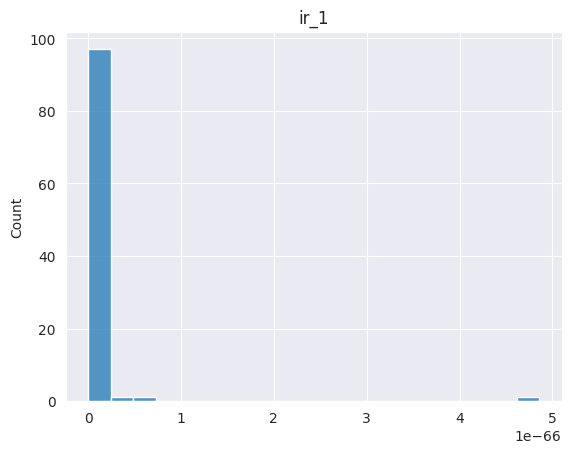

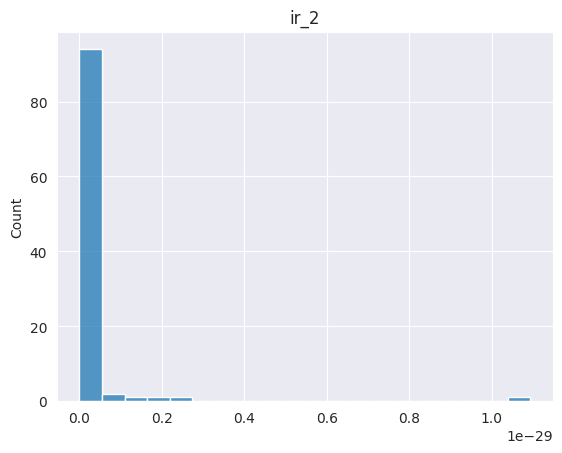

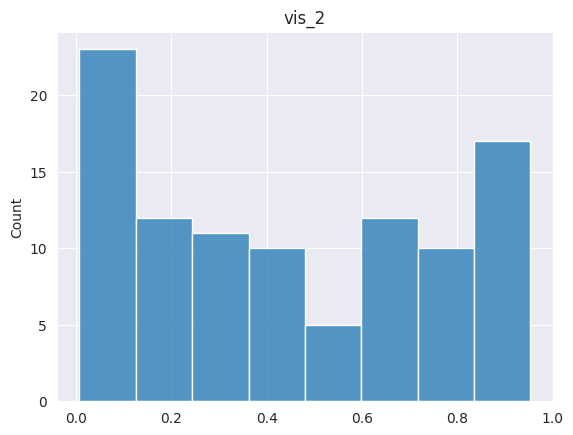

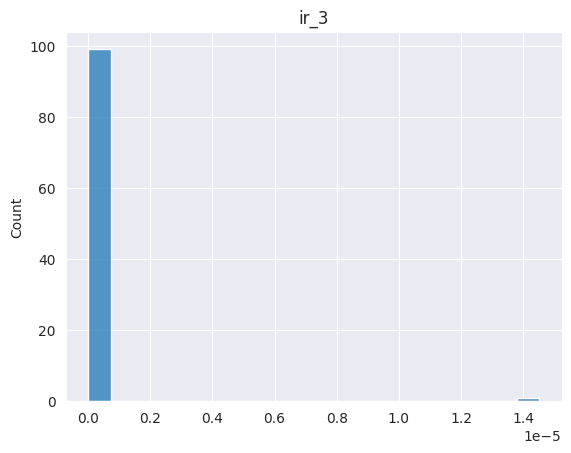

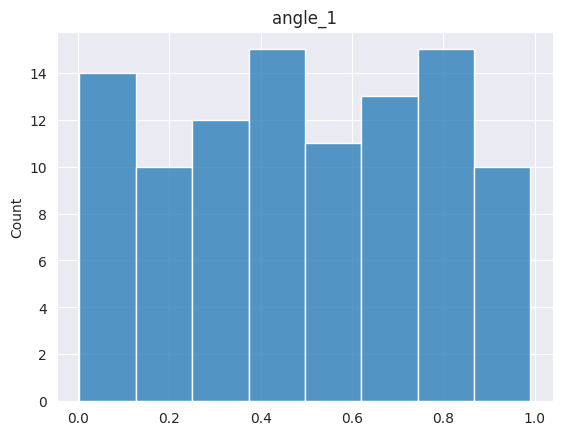

In [45]:
for var in variables:
    sns.histplot(pvals[var]).set_title(var)
    plt.show()

<mark style="background-color: #648fff;">Question:</mark> Would you say the test is valid at level $\alpha$? Explain your reasoning.

I'm not sure, what makes a level valid.

<mark style="background-color: #40E0D0;"> Task </mark> 

Using the stored p-values for `angle_1`, compute the rejection rate for different values of $\alpha$ (see variable `levels` below). Then, make a plot of the results, with `alpha` on the x-axis and the rejection rate on the y-axis. Overlay the line $y=x$ on this plot.

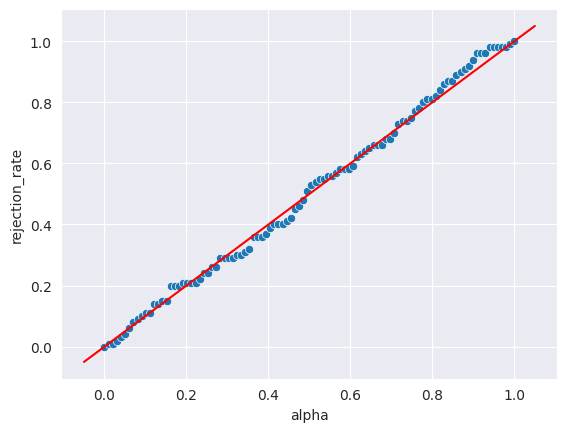

In [54]:
levels = np.linspace(0,1,100)
rejection_rates = []
for level in levels:
    rejection_rates.append({
        "alpha": level,
        "rejection_rate": sum(pvals['angle_1']<level)/len(pvals['angle_1'])
    })
rejection_rates_df = pd.DataFrame.from_records(rejection_rates)
distplot = sns.scatterplot(rejection_rates_df, x="alpha", y="rejection_rate")

# Draw a line of x=y
x0, x1 = distplot.axes.get_xlim()
y0, y1 = distplot.axes.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
distplot.axes.plot(lims, lims, '-r')



<mark style="background-color: #648fff;">Question:</mark> Does the test provide the correct level for all values of $\alpha$? Why / why not?

Of cause the points deviate slightly due to this being finite samples, but they are very close.

<mark style="background-color: #648fff;">Question:</mark> If this were an ideal test, what should the level vs. type-I error curve look like?

The level should match the x=y line perfectly.

### Using a non-parametric test

Now, let's repeat our analysis using the non-parametric [Rank-Sum test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)

In [55]:
from scipy.stats import ranksums

<mark style="background-color: #40E0D0;"> Task </mark> 

As for the t-test, compute the p-values for each variable across all of the 100 experiments. Print the rejection rates for $\alpha=0.05$ and plot the distributions of p-values as above.

The rejection rate for ir_1: 1.0
The rejection rate for ir_2: 1.0
The rejection rate for vis_2: 0.0
The rejection rate for ir_3: 1.0
The rejection rate for angle_1: 0.04


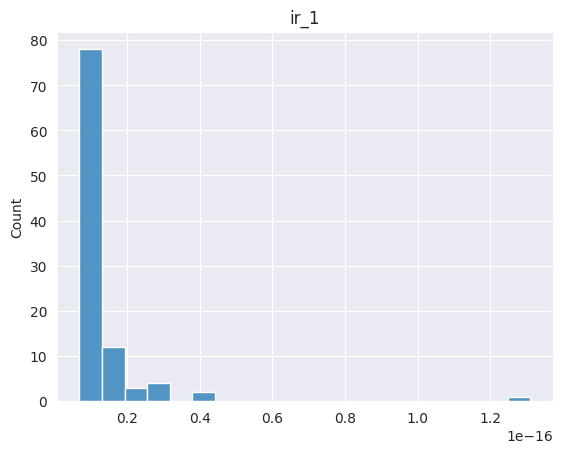

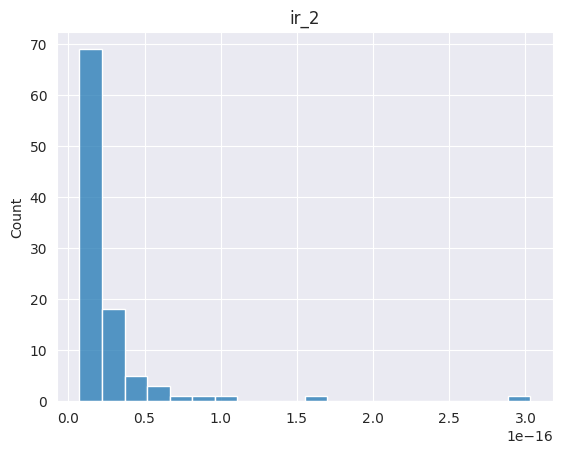

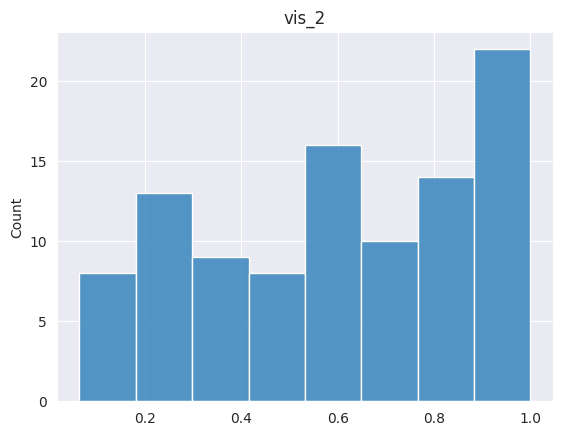

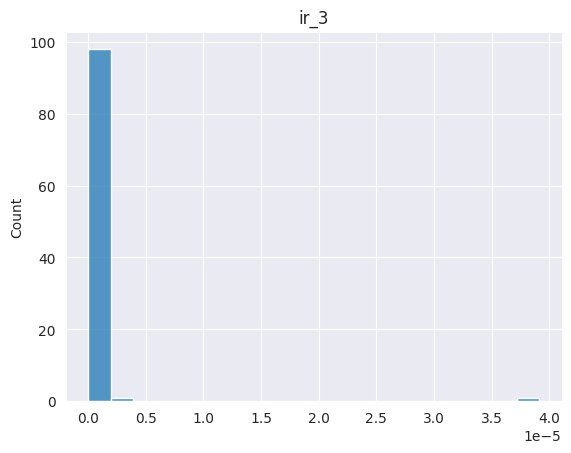

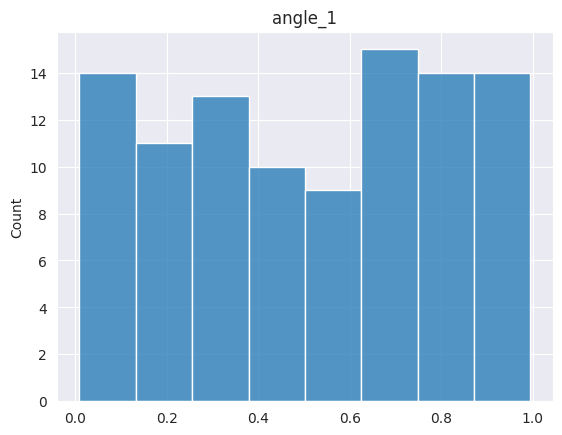

In [62]:
variables = ['ir_1', 'ir_2', 'vis_2', 'ir_3', 'angle_1']
pvals = {var: [] for var in variables}
level = 0.05

for data in dataframes:
    control_sample = data[data['red'] == 0]
    treatment_sample = data[data['red'] == 2]
    for var in variables:
        pvals[var].append(ranksums(control_sample[var], treatment_sample[var]).pvalue)
pvals

for var in variables:
    print(f"The rejection rate for {var}: {sum([pval < level for pval in pvals[var]])/len(pvals[var])}")

for var in variables:
    sns.histplot(pvals[var]).set_title(var)
    plt.show()

<mark style="background-color: #648fff;">Question:</mark> Would you say the rank-sum test is more or less powerful than the t-test? Explain your reasoning.

Since power is 1 minus the type-II-error rate and we do not have any type-II-errors for both for alpha levels above 1e-5 they seam simmilarly good.

<mark style="background-color: #648fff;">Question:</mark> Look at the distribution of p-values for `angle_1`? Why does it now follow a uniform distribution?

It stillfollows a uniform distribution since under the null hypothesis the p-values are distributed equally.

<mark style="background-color: #648fff;">Question:</mark> What will the level vs. type-I error curve look like for `angle_1`?

It should follow the line of x=y

<mark style="background-color: #40E0D0;"> Task </mark> 

Plot the level vs. type-I error curve for `angle_1` and check your answer.

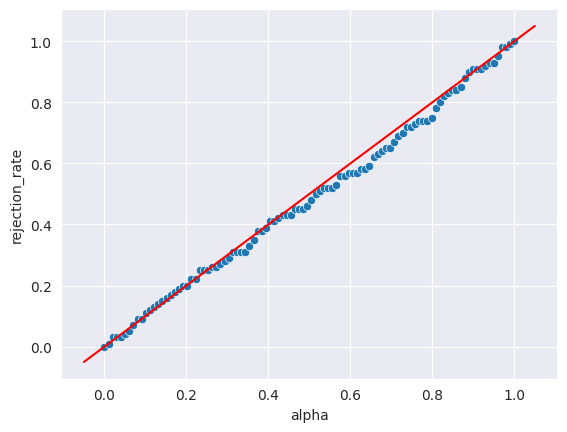

In [63]:
levels = np.linspace(0,1,100)
rejection_rates = []
for level in levels:
    rejection_rates.append({
        "alpha": level,
        "rejection_rate": sum(pvals['angle_1']<level)/len(pvals['angle_1'])
    })
rejection_rates_df = pd.DataFrame.from_records(rejection_rates)
distplot = sns.scatterplot(rejection_rates_df, x="alpha", y="rejection_rate")

# Draw a line of x=y
x0, x1 = distplot.axes.get_xlim()
y0, y1 = distplot.axes.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
distplot.axes.plot(lims, lims, '-r')

## Early-stopping

(So far, we have used a fixed sample size for our tests. Above, we collect a total of `n=100` observations between the treatment and control groups.

For some strong effects, such as the effect on `ir_1`, we might not need so many observations to be able to confidently reject the null.

Imagine now that our experiments are very expensive and we want to collect only the strictly necessary data. As a first approach, we might try "early stopping", i.e., collecting data until the null-hypothesis is rejected.

<mark style="background-color: #40E0D0;"> Task </mark> 

Write a function

```python
def simulate_early_stopping(alpha, variable):
    ...
```
where we will compute our rejection rates when we do early-stopping. The function should take in a level `alpha` and, assuming you stored the previous experiments in a list called `dataframes`, run the following procedure for the given `variable` (e.g., `ir_1` or `angle_1`).

1. Start a counter, e.g., `rejected=0` and an emtpy list `n_util_stop = []`, to store how many observations we needed until rejecting the null.
2. For each of the 100 experiments in `dataframes`, create two empty samples `sample_control` and `sample_treatment`, and add the first observation from the control (`red==0`) and treatment (`red!=0`) assignments
    1. Add the next observation to `sample_control` and `sample_treatment`, and compute the p-value of the rank-sum test
    2. If the p-value is smaller than `alpha`, reject the null. Increase the counter `rejected` and store how many observations were needed. Move on to the next experiment (step 2).
    3. If there are no more observations left in the experiment, move on to the next experiment (step 2).
    4. Otherwise, go back to (A)

Once all the experiments are done, print the resulting rejection rate (percentage) and the avg. number of observations until rejection.

In [79]:
def simulate_early_stopping(alpha, variable):
    rejected = 0
    n_until_stop = []
    for df in dataframes:
        for i in range(1, len(df)):
            p_value = ranksums(data[data['red'] == 0][variable].iloc[:i], data[data['red'] == 2][variable].iloc[:i]).pvalue
            if p_value < alpha:
                rejected += 1
                n_until_stop.append(i)
                break
    # Print results
    print(f"Rejection rate for {variable}: {rejected / len(dataframes) * 100}%")
    print(f"avg. no. of observations {variable}: {np.mean(n_until_stop)}")

<mark style="background-color: #40E0D0;"> Task </mark> 

Now, compute the rejection rate and observations-to-rejection for `'ir_1', 'ir_2', 'vis_2', 'ir_3'`.

In [80]:
vars = ['ir_1', 'ir_2', 'vis_2', 'ir_3']
for var in vars:
    simulate_early_stopping(0.05, var)

Rejection rate for ir_1: 100.0%
avg. no. of observations ir_1: 3.0
Rejection rate for ir_2: 100.0%
avg. no. of observations ir_2: 3.0
Rejection rate for vis_2: 0.0%
avg. no. of observations vis_2: nan


/home/margarete/PycharmProjects/potsdam-25-ml-theory-to-practice/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/margarete/PycharmProjects/potsdam-25-ml-theory-to-practice/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Rejection rate for ir_3: 100.0%
avg. no. of observations ir_3: 9.0


<mark style="background-color: #648fff;">Question:</mark> Are the rejection rates lower or higher than in our previous experiment?

The rejection rates are exactly the same as bevore.

<mark style="background-color: #648fff;">Question:</mark> For each variable, how many observations did we use until rejection? Why are these numbers different?

We used very few samples with, 3, 3 and 9 samples. They probably differ due to the distributions having differently large intersection with the null distribution.

<mark style="background-color: #40E0D0;"> Task </mark> 

Now, compute the rejection rate and observations-to-rejection for `angle_1`.

In [84]:
simulate_early_stopping(0.05, "angle_1")

Rejection rate for angle_1: 100.0%
avg. no. of observations angle_1: 11.0


<mark style="background-color: #648fff;">Question:</mark> What is the rejection rate now? Why is this happening? Would you use this "early-stopping" approach in practice?

the rejection rate is 100%. With very few samples it is more likely to have a high error and therefore it is likely that for some small sample number the p-value is low enough for rejection. I would not use "early-stopping", st least not in an unmodified way.

## Two-sample tests for other kinds of data

For this part we will use an existing dataset composed of images collected from the light tunnel.

To download it, first choose where it should be download it

In [85]:
DOWNLOAD_DIR = './'

and download it

In [86]:
from causalchamber.datasets import Dataset

# Download the dataset and store it, e.g., in the current directory
dataset = Dataset('lt_color_regression_v1', root=DOWNLOAD_DIR, download=True)

100%|██████████| 4.99G/4.99G [03:05<00:00, 26.8MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "./"... done.


The dataset (description [here](https://github.com/juangamella/causal-chamber/tree/main/datasets/lt_color_regression_v1)) consists of experiments where the light source color is set at random, and images are captured under different configurations of the polarizer and camera sensors.

Let's load two of these experiments.

In [87]:
# Load the observations and images from an experiment (see experiment names below)
# Choose
sample_a = dataset.get_experiment(name='reference').as_image_array(size='100')
sample_b = dataset.get_experiment(name='pol_1_45').as_image_array(size='100')

in the first experiment, the first polarizer is kept at `pol_1=0` degrees, while in the second it is kept at `pol_1=45` degrees.

Let's explore the dataset by plotting some images:

In [88]:
def plot_random_images(sample, n=5, seed=42):
    plt.figure(figsize=(n*2, 2))
    rng = np.random.default_rng(seed)
    for i,j in enumerate(rng.integers(len(sample), size=n)):
        plt.subplot(1,n,i+1)
        plt.imshow(sample[j])        

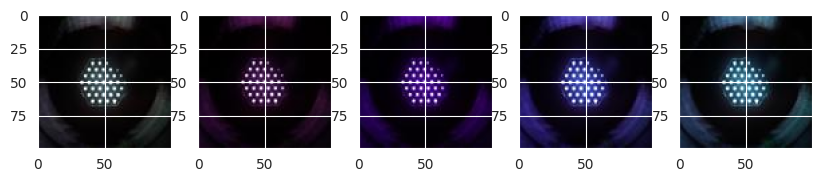

In [89]:
plot_random_images(sample_a)

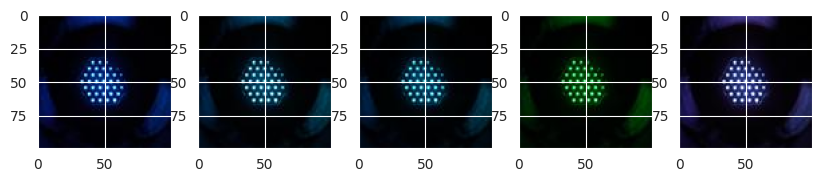

In [90]:
plot_random_images(sample_b)

As you can see, it is quite hard to tell the difference at plain sight. If you look closer, you can notice the difference int the shape of the blur on the top of the image.

That's quite a subtle difference.

<mark style="background-color: #648fff;">Question:</mark> How can we test if these two samples are different? How would you apply the t-test or rank-sum test to solve this problem?

Write down some ideas and we'll brainstorm in class next week.

- first calculate how blurry an image is, then use the t-test/rank-sum test


Next week (project 3) we will build a two-sample test using a neural network. This is a modern approach that you can use to build two-sample tests for virtually any kind of data.

Here is the recommended reading.

> [[Link](https://insightful-data-lab.com/2025/08/23/classifier-two-sample-tests-c2sts/)] A quick bullet-point primer
> 
> [[PDF](https://arxiv.org/pdf/1610.06545)] Lopez-Paz, David, and Maxime Oquab. "Revisiting classifier two-sample tests." arXiv preprint arXiv:1610.06545 (2016).